# 10 Step Phase Shifting Technique

In [49]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%autoreload 2

In [51]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from functions import load_raw_img, rad_to_deg, mask_to_dummy
from unwrapping_algorithm import phase_unwrap

### Load the 10 images

In [52]:
base_path = "img/disc/phase-shifting/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [53]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


In [66]:
mask = cv.imread('img/disc/mask/disc_mask_phase_shifting_2.jpg', cv.IMREAD_GRAYSCALE)

### Calculate the isoclinic parameter
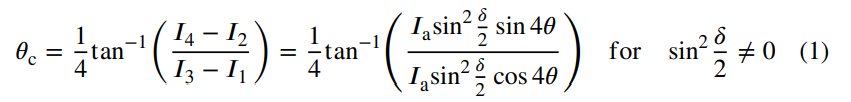

In [54]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [55]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

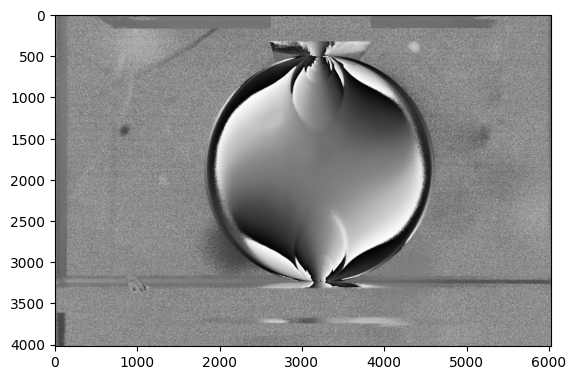

In [67]:
plt.imshow(isoclinic_param, cmap='gray')
plt.imsave('img/disc/results/disc_isocl_wr.jpg', isoclinic_param, cmap='gray')

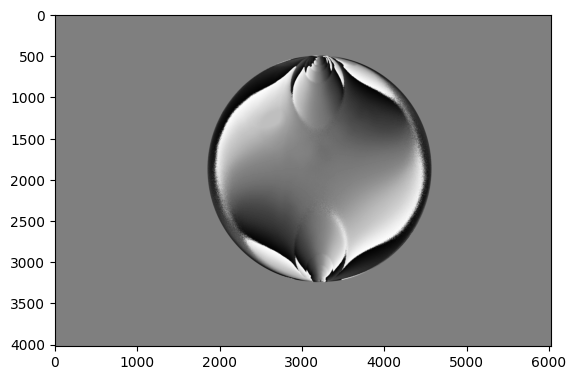

In [68]:
isoclinic_masked = cv.multiply(isoclinic_param, mask / 255)
plt.imshow(isoclinic_masked, cmap='gray')
plt.imsave('img/disc/results/disc_isocl_wr_masked.jpg',  isoclinic_masked, cmap='gray')

### Generate isochromatic parameter
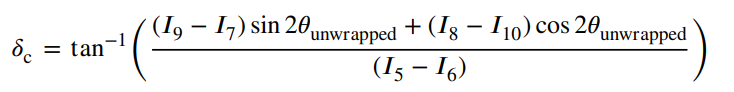


In [57]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [58]:
isochromatic_param_rad = np.nan_to_num(generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_param
))

C:\Users\zebsu\AppData\Local\Temp\ipykernel_37428\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\zebsu\AppData\Local\Temp\ipykernel_37428\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


Translate `isochromatic_param` values from `(-pi/2, pi/2)` to `(0, 255)`

In [59]:
isochromatic_param = (isochromatic_param_rad + np.pi/2)*255/(np.pi)

## Isochromatic Image Processing

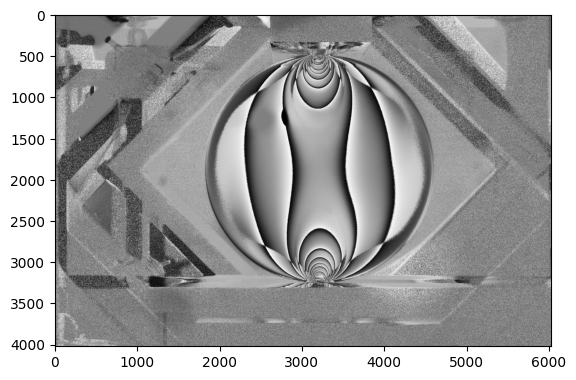

In [65]:
plt.imshow(isochromatic_param, cmap='gray')
plt.imsave('img/disc/results/disc_isochr_wr.jpg', isochromatic_param, cmap='gray')

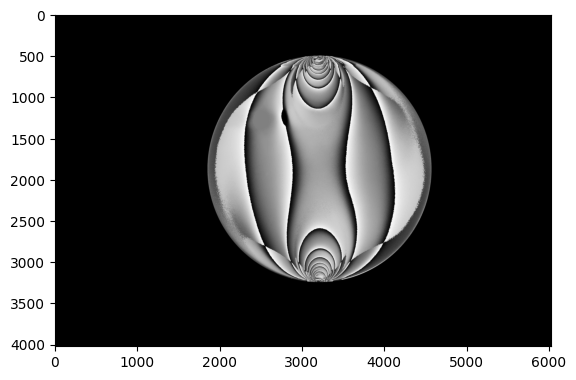

In [72]:
isochromatic_masked = cv.multiply(isochromatic_param, mask / 255)
isochromatic_masked = cv.medianBlur(isochromatic_masked.astype(np.uint8), 5)

plt.imshow(isochromatic_masked, cmap='gray')
plt.imsave('img/disc/results/disc_isochr_wr_masked.jpg',  isochromatic_masked, cmap='gray')

Generate dummy

In [62]:
# Set stack as isotropic points
stack = [(2000, 2200), (2000, 4200)]
#create dummy array to be populated by unwrapped pixels
dummy = mask_to_dummy(mask)

# Unwrap
img_unwrapped = phase_unwrap(isochromatic_masked, stack, dummy)

0 2
300000 2188
600000 2947
900000 3305
1200000 3581
1500000 3792
1800000 3929
2100000 3824
2400000 3975
2700000 4077
3000000 3904
3300000 3613
3600000 3431
3900000 3231
4200000 3005
4500000 2749
4800000 2456
5100000 2096
5400000 1624
5700000 844


In [1]:
plt.imshow(img_unwrapped, cmap='gray')
plt.imsave('img/disc/results/disc_isochr_unwr_masked.jpg', np.nan_to_num(img_unwrapped), cmap='gray')

NameError: name 'plt' is not defined

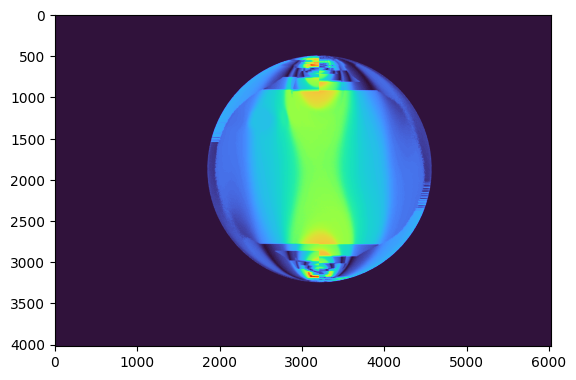

In [73]:
img = cv.medianBlur(cv.imread('img/disc/results/disc_isochr_unwr_masked.jpg', cv.IMREAD_GRAYSCALE), 5) 
plt.imshow(img, cmap='turbo')